## Dekoder tonskog biranja

### Opis zadatka

Tonsko biranje ili dual-tone multifrequency (DTMF) signalizacija je vrsta in-band
signalizacije u telekomunikacijama (signalizacija se prenosi istim kanalom i u istom
frekvencijskom opsegu kao i govor, odnosno, podaci). Na telefonima sa tonskim
biranjem pritisak na taster generiše signal koji se sastoji od dva tona koji se dekoduju u
centrali kako bi se identifikovao pozvani telefonski broj. Proces dekodovanja se sastoji
od određivanja frekvencija dva tona od kojih se sastoji signal. Frekvencije tonova su
propisane ITU standardom i dodijeljene su tasterima na način prikazan na sledećoj slici:


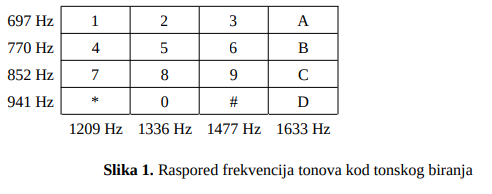

Dakle, pritiskom na taster 1, generiše se složenoperiodični signal koji se sastoji od
sinusoida frekvencija 697 Hz i 1209 Hz. Signali kod kojih je viša frekvencija 1633 Hz
trenutno se ne koriste za tonsko biranje u telefonima, ali postoji njihova upotreba u nekim
specijalizovanim aplikacijama kao što su vojska, radio-amateri ili privatne telefonske
centrale. ITU propisuje minimalno trajanje tona od 40 ms.
U početku, DTMF signali su dekodovani pomoću analognih filtara propusnika opsega
čije centralne frekvencije odgovaraju frekvencijama komponenata tonova. Sa pojavom
digitalne obrade signala ukazala se mogućnost za jeftiniju i fleksibilniju implementaciju
DTMF dekodera tehnikama zasnovanim na Furijeovoj transformaciji.
Cilj ovog rada je implementacija dekodera DTMF signala korištenjem vremenski zavisne
Furijeove transformacije (STFT). Za testiranje vaših ideja i implementacija data su 3
DTMF signala koji se nalaze u fajlu dtmf.zip. U svakom od fajlova nalazi se po jedan
signal kojim je kodovan šestocifreni telefonski broj. Prvi signal je u fajlu dtmf1.mat i
u njemu nema šuma niti drugih poremećaja. Drugi signal je u fajlu dtmf2.mat i
narušen je samo Gausovim bijelim šumom nulte srednje vrijednosti i varijanse 0.5477.
Treći signal je u fajlu dtmf3.mat i narušen je interferencijom koja je uskopojasni
signal (sinusoida) čija se frekvencija mijenja kontinualno u vremenu i Gausovim bijelim
šumom sa istim parametrima kao i u signalu dtmf2. Frekvencija odmjeravanja u svakom
od signala je 8 kHz, trajanje tonova je između 40 i 100ms, a između tonova su pauze
fiksne dužine od 40ms. MAT fajlove možete učitati korištenjem metoda loadmat iz
modula scipy.io.

#### 1. Izabrati parametre STFT: dužinu i tip prozora, preklapanje prozora, broj tačaka DFT. Ovdje imajte u vidu trajanje pojedinih tonova i njihove frekvencije. Curenje spektra nećete moći u potpunosti izbjeći, ali nastojte da izaberete broj tačaka DFT tako da dobijete odmjeravanje u frekvenciji koje što je moguće bolje odgovara frekvencijama tonova;

1. <b>Dužina prozora </b>: Trebamo izabrati dužinu prozora koja je dovoljna da obuhvati najmanje jedan period najniže frekvencije (697 Hz), što znači da prozor treba biti dužine najmanje $ \frac{\displaystyle 1}{\displaystyle 697} ≈ 1.43ms$. Međutim, pošto je minimalno trajanje tona 40 ms, dužina prozora bi mogla biti 40 ms ili više.
2. <b> Tip prozora </b>: Najčešće korišteni prozori su Hamming ili Hann prozori zbog njihovih dobrih osobina u smislu smanjenja curenja spektra. Koristićemo Hann-ov prozor, što se eksperimentalno pokazalo kao najbolja opcija, pošto daje najljepše rezultate.
3. <b> Preklapanje prozora </b>: Obično se koristi preklapanje od 50% ili više kako bismo dobili dobru vremensku rezoluciju.
4. <b> Broj tačaka DFT </b>: Trebamo izabrati broj tačaka DFT tako da dobijemo dovoljnu rezoluciju u frekvencijskom domenu, što znači da frekvencijska rezolucija treba biti manja od razlike između najbližih tonova, tj. 77 Hz. Sa frekvencijom odmjeravanja od 8 kHz, broj tačaka DFT bi trebao biti najmanje $\frac{\displaystyle 8000}{\displaystyle 77} ≈ 104$. Međutim, zbog uslova da nam dužina prozora mora biti najmanje 40ms, što je kada se izračuna $nperseg=t*F_{s}=0.04*8000=320 $, vidimo da je dužina prozora 320 odmjeraka, a broj tačaka DFT mora biti veći ili jednak dužini prozora. Iz tog razloga ćemo uzeti N=512, jer je veće od 320, a zapravo je vrijednost $2^{n}$, što nam daje optimalnije rezultate. Sa većim brojem tačaka dobijamo bolju frekvencijsku rezoluciju.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import stft, hann, hamming, blackmanharris, flattop, istft

# Parametri
fs = 8000  # Frekvencija odmjeravanja 8 kHz
nperseg = int(0.04*fs) # Dužina prozora za 40ms (320)
noverlap = nperseg*0.5  # Preklapanje od 50%
nfft = 512  # Broj tačaka DFT

# Učitavanje signala i prikaz ključeva
mat_contents1 = loadmat('dtmf1.mat')
print("Keys in dtmf1.mat:", mat_contents1.keys())

mat_contents2 = loadmat('dtmf2.mat')
print("Keys in dtmf2.mat:", mat_contents2.keys())

mat_contents3 = loadmat('dtmf3.mat')
print("Keys in dtmf3.mat:", mat_contents3.keys())


Keys in dtmf1.mat: dict_keys(['__header__', '__version__', '__globals__', 'dtmf1'])
Keys in dtmf2.mat: dict_keys(['__header__', '__version__', '__globals__', 'dtmf2'])
Keys in dtmf3.mat: dict_keys(['__header__', '__version__', '__globals__', 'dtmf3'])


Vidimo da je ključ za učitavanje podataka zapravo samo ime fajla

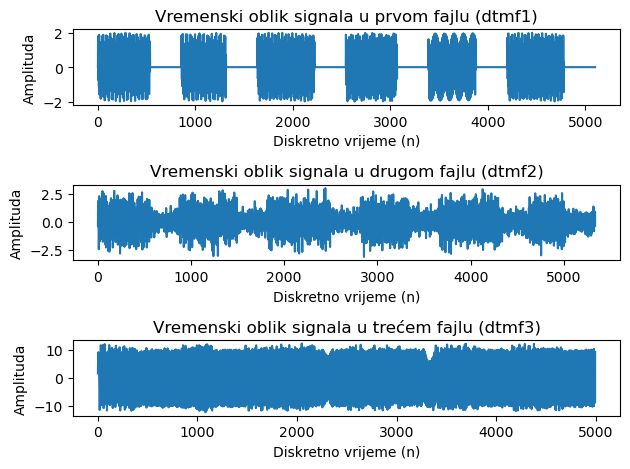

Shape of data1: (5101,)
Shape of data2: (5338,)
Shape of data3: (4993,)


In [15]:
data1 = mat_contents1['dtmf1'].flatten()
data2 = mat_contents2['dtmf2'].flatten()
data3 = mat_contents3['dtmf3'].flatten()

plt.figure()
plt.subplot(311)
plt.plot(data1)
plt.xlabel('Diskretno vrijeme (n)')
plt.ylabel('Amplituda')
plt.title('Vremenski oblik signala u prvom fajlu (dtmf1)')
plt.subplot(312)
plt.plot(data2)
plt.xlabel('Diskretno vrijeme (n)')
plt.ylabel('Amplituda')
plt.title('Vremenski oblik signala u drugom fajlu (dtmf2)')
plt.subplot(313)
plt.plot(data3)
plt.xlabel('Diskretno vrijeme (n)')
plt.ylabel('Amplituda')
plt.title('Vremenski oblik signala u trećem fajlu (dtmf3)')
plt.tight_layout()
plt.show()

# Provjera oblika i dužine signala
print("Shape of data1:", data1.shape)
print("Shape of data2:", data2.shape)
print("Shape of data3:", data3.shape)

U prvom fajlu jasno vidimo sekvencu od 6 cifara, te da fajl ima 5101 odmjeraka. U drugom fajlu ne možemo da prepoznamo od koliko cifara se sastoji sekvenca koja je predstavljena datim signalom, jer je signal narušen Gausovim bijelim šumom, ali vidimo da signal ima 5338 odmjeraka, dok u trećem signalu takođe ne vidimo nikakvu sekvencu, jer je signal narušen i Gausovim bijelim šumom i interferencijom koja je uskopojasni signal (sinusoida) čija se frekvencija mijenja kontinualno u vremenu. Vidimo da se signal sastoji od 4993 odmjerka.

#### 2. Prikazati spektrogram signala. Broj koji je kodovan se sada može „pročitati“ iz spektrograma

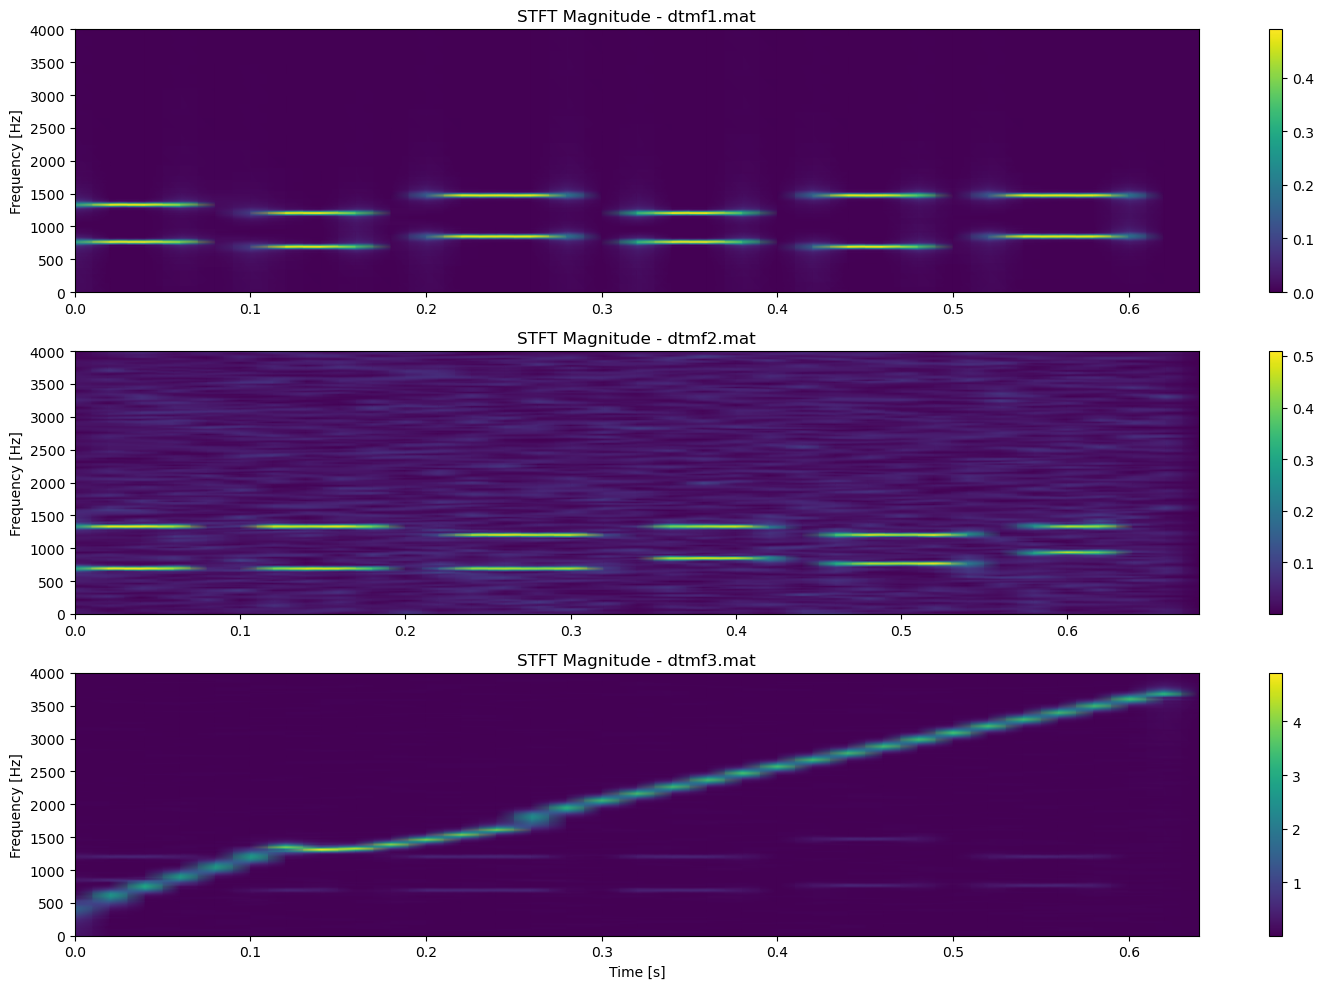

In [16]:
window = hann(nperseg)  # Hannov prozor


# STFT
f1, t1, Zxx1 = stft(data1, fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
f2, t2, Zxx2 = stft(data2, fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
f3, t3, Zxx3 = stft(data3, fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)


# Plotovanje STFT za svaki signal
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.pcolormesh(t1, f1, np.abs(Zxx1), shading='gouraud')
plt.title('STFT Magnitude - dtmf1.mat')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.pcolormesh(t2, f2, np.abs(Zxx2), shading='gouraud')
plt.title('STFT Magnitude - dtmf2.mat')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

plt.subplot(3, 1, 3)
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.title('STFT Magnitude - dtmf3.mat')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

plt.tight_layout()
plt.show()


Atribut funkcije pcolormash shading='gouraud' čini prelaze između različitih boja glatkijima, što može pomoći u boljem razumevanju kontinuiranih promena u podacima. 'flat' shading može biti bolji za identifikaciju oštrih promjena ili diskretnih skokova u podacima, što ovdje nije slučaj. Međutim, sa 'gouraud' možemo da narušimo performanse, jer može biti računski zahtevniji, posebno za velike skupove podataka, jer zahtjeva interpolaciju između vrijednosti. 


Na prvom spektogramu jasno vidimo i visoke i niske frekvencije iz kojih možemo da pročitamo sekvencu brojeva, a to je 6   <br>
Na drugom spektogramu vidimo da postoji Gausov šum, međutim zbog dobrog odabira parametara STFT-a i takvog odnosa vremenske i frekvencijske rezolucije, poprilično jasno se vide i visoke i niske frekvencije. <br>
Na trečem spektogramu vidimo da su smetnje jako velike, ali da se sekvenca opet vidi, međutim mnogo su manje izražene frekvencije visoke i niske frekvencije, jer smetnja zapravo ima najizraženiju frekvenciju. <br>
Probaćemo da umanjimo uticaj smetnje promjenom STFT parametara.

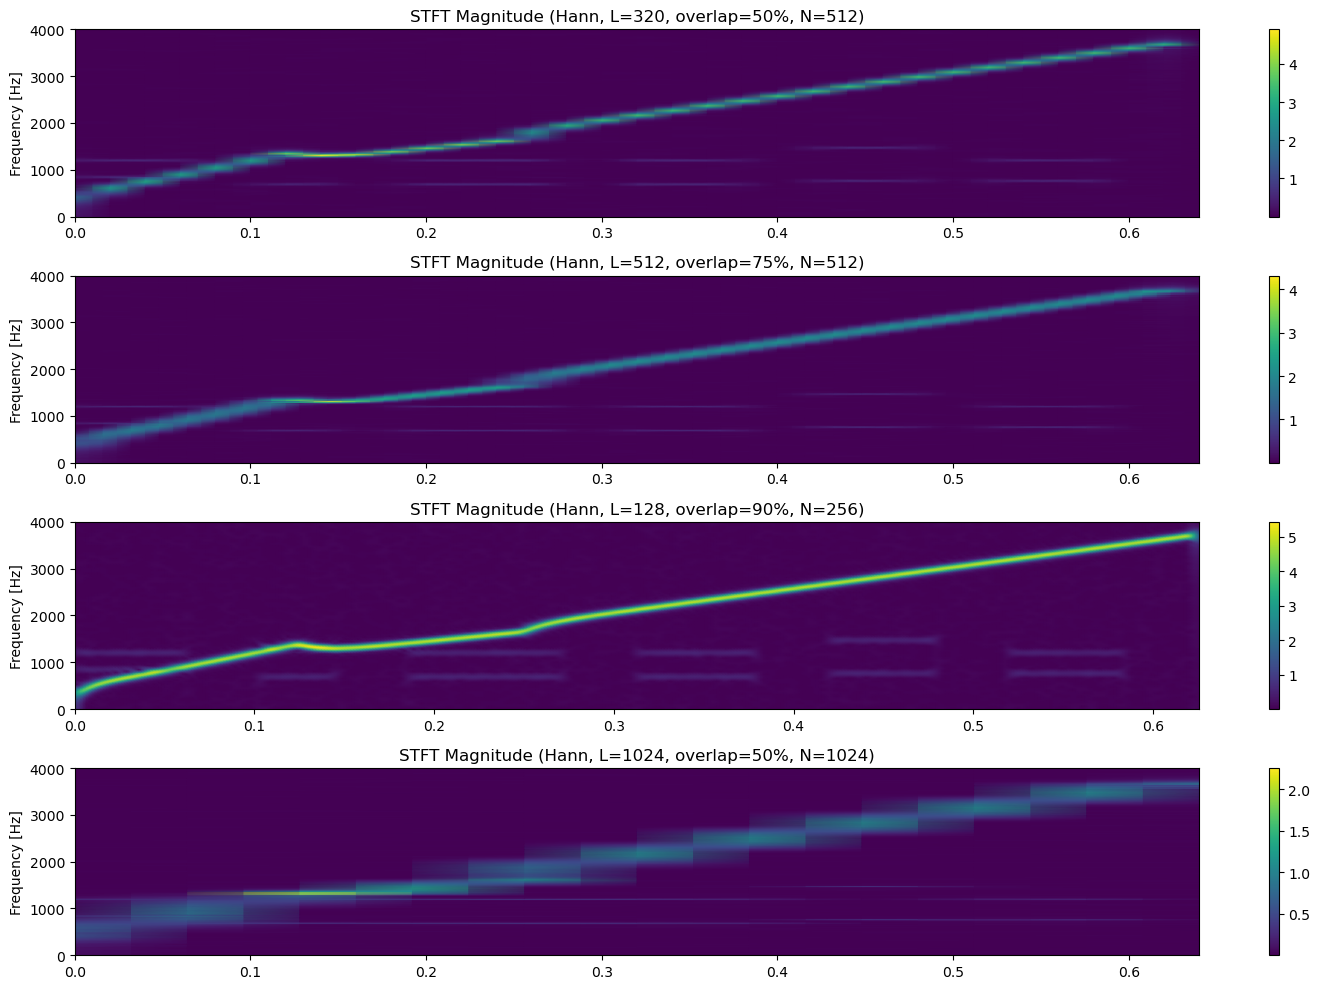

In [17]:
nperseg1=512 #Dužina prozora je sad 400
window1=hann(nperseg1) 
noverlap1=nperseg1*0.75 #Preklapanje je 75%
nfft1=512
f3_1, t3_1, Zxx3_1 = stft(data3, fs, window=window1, nperseg=nperseg1, noverlap=noverlap1, nfft=nfft1)

nperseg2=128 #Dužina prozora je 128
window2=hann(nperseg2) #Koristimo Hannov prozor
noverlap2=nperseg2*0.90 #Preklapanje 90%
nfft2=256 #Dužina DFT-a je 512
f3_2, t3_2, Zxx3_2 = stft(data3, fs, window=window2, nperseg=nperseg2, noverlap=noverlap2, nfft=nfft2)

nperseg3=1024 #Dužina prozora je 1024
window3=hann(nperseg3) #Koristimo Hannov prozor
noverlap3=nperseg3*0.5 #Preklapanje 90%
nfft3=1024 #Dužina DFT-a je 1024
f3_3, t3_3, Zxx3_3 = stft(data3, fs, window=window3, nperseg=nperseg3, noverlap=noverlap3, nfft=nfft3)


plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.pcolormesh(t3, f3, np.abs(Zxx3), shading='gouraud')
plt.title('STFT Magnitude (Hann, L=320, overlap=50%, N=512)')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

plt.subplot(4, 1, 2)
plt.pcolormesh(t3_1, f3_1, np.abs(Zxx3_1), shading='gouraud')
plt.title('STFT Magnitude (Hann, L=512, overlap=75%, N=512)')
plt.ylabel('Frequency [Hz]')
plt.colorbar()


plt.subplot(4, 1, 3)
plt.pcolormesh(t3_2, f3_2, np.abs(Zxx3_2), shading='gouraud')
plt.title('STFT Magnitude (Hann, L=128, overlap=90%, N=256)')
plt.ylabel('Frequency [Hz]')
plt.colorbar()

plt.subplot(4, 1, 4)
plt.pcolormesh(t3_3, f3_3, np.abs(Zxx3_3), shading='gouraud')
plt.title('STFT Magnitude (Hann, L=1024, overlap=50%, N=1024)')
plt.ylabel('Frequency [Hz]')
plt.colorbar()



plt.tight_layout()
plt.show()


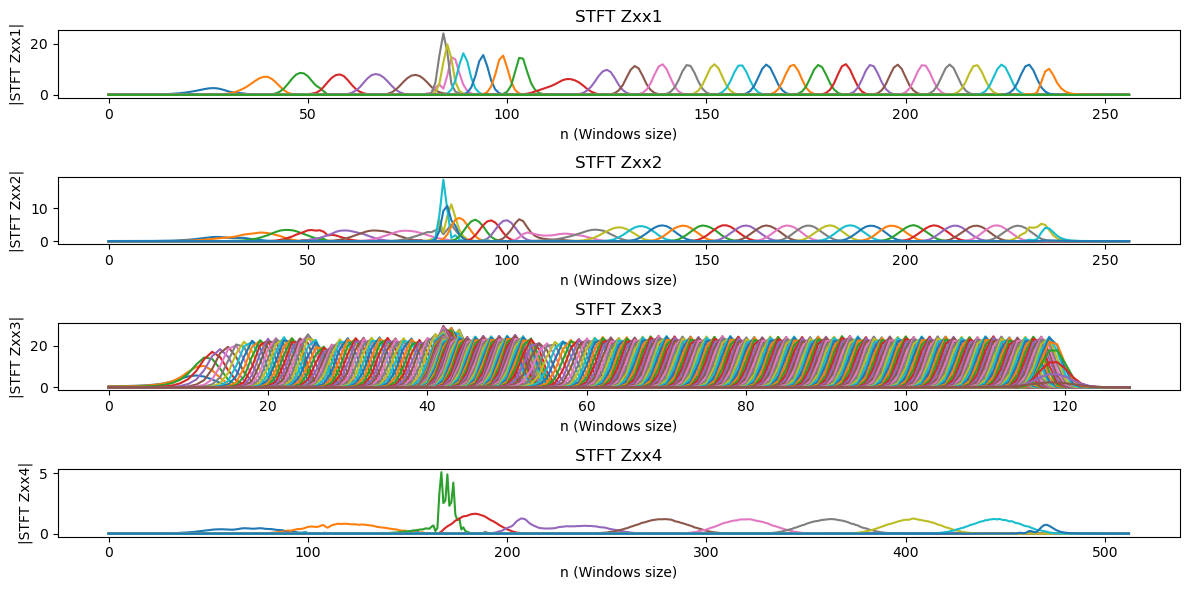

In [5]:

magnitude1 = np.abs(Zxx3)**2
magnitude2 = np.abs(Zxx3_1)**2
magnitude3 = np.abs(Zxx3_2)**2
magnitude4 = np.abs(Zxx3_3)**2

plt.figure(figsize=(12, 6))
plt.subplot(4,1,1)
plt.plot(magnitude1)
plt.ylabel('|STFT Zxx1|')
plt.xlabel('n (Windows size)')
plt.title('STFT Zxx1')



plt.subplot(4,1,2)
plt.title('STFT Zxx2')
plt.ylabel('|STFT Zxx2|')
plt.xlabel('n (Windows size)')
plt.plot(magnitude2)


plt.subplot(4,1,3)
plt.title('STFT Zxx3')
plt.ylabel('|STFT Zxx3|')
plt.xlabel('n (Windows size)')
plt.plot(magnitude3)


plt.subplot(4,1,4)
plt.title('STFT Zxx4')
plt.ylabel('|STFT Zxx4|')
plt.xlabel('n (Windows size)')
plt.plot(magnitude4)

plt.tight_layout()
plt.show()

<b> Uticaj parametara na rezoluciju </b>

1. Dužina prozora (window length):
<i>Vremenska rezolucija: </i> Kratki prozori omogućavaju bolju vremensku rezoluciju jer obuhvataju kraće vremenske intervale. To znači da bolje prati brze promjene u signalu.
<i>Frekvencijska rezolucija: </i> Dugi prozori omogućavaju bolju frekvencijsku rezoluciju jer duži segmenti signala omogućavaju precizniju analizu frekvencijskih komponenti. Međutim, to dolazi na račun vremenske rezolucije.

2. Vrsta prozora (window type):
Različiti prozori (npr. Hamming, Hanning, Blackman) imaju različite efekte na curenje spektra u frekvencijskom spektru.
<i>Hamming i Hanning prozori: </i> Smanjuju curenje spektra i omekšavaju prelaze između segmenata, što može poboljšati frekvencijsku rezoluciju za račun promjene amplitude.
<i>Rectangular prozor: </i> Daje bolju vremensku rezoluciju, ali slabiju frekvencijsku rezoluciju zbog značajnog curenja spektra .

3. Preklapanje (overlap):
<i> Veće preklapanje: </i> Poboljšava vremensku rezoluciju jer više uzoraka signala se analizira, što omogućava bolju detekciju promjena. Tipično se koristi preklapanje od 50% do 75%.
<i> Manje preklapanje: </i> Smanjuje računsku kompleksnost, ali može dovesti do gubitka detalja u vremenskom domenu.

4. Veličina FFT-a (FFT size):
<i> Veća FFT veličina: </i> Poboljšava frekvencijsku rezoluciju jer omogućava analizu više frekvencijskih komponenti unutar istog prozora. Međutim, to može povećati računsku kompleksnost.
<i> Manja FFT veličina: </i> Poboljšava vremensku rezoluciju jer se analizira manji broj frekvencijskih komponenti, ali dolazi na račun frekvencijske rezolucije.

<b> Primjer efekata parametara </b> <br>
<i>Kratak prozor (128 tačaka) sa velikim preklapanjem (75%):</i> Dobar za analizu brzih promjena u signalu (dobra vremenska rezolucija), ali lošija frekvencijska rezolucija. <br>
<i>Dugačak prozor (1024 tačaka) sa malim preklapanjem (50%): </i> Dobar za analizu stabilnih frekvencijskih komponenti (dobra frekvencijska rezolucija), ali lošija vremenska rezolucija.<br>

Uticaj ovih parametara je vidljiv na spektogramima iznad. <br>
Na 3. spektogramu vidimo da, ukoliko je veličina prozora mala i preklapanje veliko, dominantna frekvencija nam je zapravo frekvencija sinusoide koja se mjenja vremenom, a to nam je zapravo šum, koji trebamo eliminisati, samim tim, taj izbor nam nije povoljan. <br>
Ukoliko je dužina prozora 1024 (spektogram 4), uticaj smetnje nije toliko dominantan, ali dobijamo preklapanje naše sekvence i ne možemo da pročitamo frekvencije. Razlog tome je što je trajanje tonova u sekvenci od 40ms do 100ms i ukoliko uzmemo veličinu prozora 1024 dobijamo $L=F_{s}*t => t= \frac {\displaystyle L}{\displaystyle F_{s}}= \frac {\displaystyle 1024}{\displaystyle 8000}=0.128s=128ms$. Dakle, ovim izborom parametara dakle dolazi do preklapanja frekvencija 2 različita broja, što nije poželjno. <br>

Spektogrami 1 i 2 su dosta slični, razlika se primjeti samo u rezoluciji šuma, a vrijednosti visokih i niskih frekvencija su relativno jednako vidljive na oba spektograma, tako da ćemo zapravo za daljnju analizu koristiti parametre koje smo izabrali na početku, a to su: dužina prozora (L) = 320, preklapanje je 50%, a broj tačaka u DFT-u je 512, te se koriti Hannov prozor. <br>

Takođe i po spektru STFT-a vidimo da smetnje mnogo utiču na vrijednosti, međutim, najbolje očitavanje dobijamo za prvi slučaj.

#### 3. Napraviti dekoder koji će automatski određivati koji je broj kodovan datim signalom i ispisati ga na ekranu;

In [6]:
def check_low_freq(array, n=1000, m=650):
    has_smaller_than_n = False
    has_greater_than_m = False
    
    for element in array:
        if element < n:
            has_smaller_than_n = True
        if element > m:
            has_greater_than_m = True
        
        # Ako su oba uslova ispunjena, odmah vratiti True
        if has_smaller_than_n and has_greater_than_m:
            return True
    
    
    return False


def check_high_freq(array, n=1670, m=1150):
    has_smaller_than_n = False
    has_greater_than_m = False
    
    for element in array:
        if element < n:
            has_smaller_than_n = True
        if element > m:
            has_greater_than_m = True
        
        # Ako su oba uslova ispunjena, odmah vratiti True
        if has_smaller_than_n and has_greater_than_m:
            return True
    
    return False

Ovaj kod provjerava da li u odabranim frekvencijama postoji odgovarajuća frekvencija za nisku frekvenciju, te za visoku frekvenciju tona tastera. 

In [7]:
def decode_dtmf(ddata, dfs, dwindow, dnperseg, dnoverlap, dnfft):
    f, t, Zxx = stft(ddata, dfs, window=dwindow, nperseg=dnperseg, noverlap=dnoverlap, nfft=dnfft)    

    # Magnitude
    magnitude = np.abs(Zxx)**2

    # Prag za detekciju frekvencija
    threshold = 0.5 * np.max(magnitude)
    
    i=0
    # Detekcija frekvencija po segmentima vremena
    detected_freqs = []
    detected_freqs_filt = []
    p= []
    for i in range(magnitude.shape[1]): #Tražimo frekvencije po vremenu
        freqs = f[np.where(magnitude[:, i] > threshold)]
        i+=1
        if len(freqs)>=2 and check_low_freq(freqs) and check_high_freq(freqs):  # Trebaju nam dvije frekvencije
            detected_freqs.append((np.min(freqs), np.max(freqs)))
            p=[np.min(freqs), np.max(freqs)]
            
        else:
            if len(p) >=2:
                detected_freqs_filt.append(p)
                p=[]

            
    # Mapa frekvencija tastera sa odgovarajucim simbolom
    dtmf_map = {
        (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
        (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
        (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
        (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
    }
    
    # Dekodovanje signala
    decoded_digits = []
    for low, high in detected_freqs_filt:
        for (lf, hf), digit in dtmf_map.items():
            if np.abs(low - lf) < 35 and np.abs(high - hf) < 35: #Tolerancija od 35Hz, preko tog bi došlo do preklapanja cifri
                decoded_digits.append(digit)
                break
    
    # Izbacivanje duplikata uzrokovanih preklapanjem prozora (izbacice i ako imaju 2 ista tona jedan do drugog)
    #decoded_digits = [digit for i, digit in enumerate(decoded_digits) if i == 0 or digit != decoded_digits[i - 1]]
    
    return ''.join(decoded_digits)        
    
    

U ovom kodu se za dtmf.mat zapis pravi STFT tranfsormacija, pomoću koje dobijamo vremenske segmente, frekvecnije i amplitude (magnitude) datog signala. Kada dobijemo vrijednosti provjeravamo da li te magnitude zadovoljavaju napon praga, koji sami postavljamo. Na taj način eliminišemo male magnitude, koje su posljedica nekih šumova, te i segmenata bez dominantnih frekvencija. Kada na taj način ekstrahujemo frekvencije, prvo brišemo sve duplikate, koji nastaju iz razloga što se u više vremenskih segmenata javlja ista frekvencija. Ovom problemu bismo mogli pristupiti naivno, te pobrisati sve duplikate iz dekodovanih brojeva. Međutim, ukoliko je dva puta za redom, sa kratkom pauzom, pritisnut isti taster, to ne bismo mogli učitati. Rješenje za taj problem je da se u jednom nizu segmenata, u kome su frekvencije relativno jednake, bez nekog velikog pada frekvencija, zapamti samo jedna vrijednost, a kada se ponovo pojave odgovarajuće frekvencije, pamti se iduća vrijednost. Nakon tog, provjeravamo u mapi dtmf-a da li postoji simbol za tu kombinaciju niskih i visokih frekvencija. <br>
Ovakva implementacija sadrži jedan problem, a to je da, ukoliko se u nekom segmetnu pojavljuju odgovarajuće frekvencije, ali postoje i druge dominantne frekvencije, koje su manje od minimalne niske frekvencije ili veće od maksimalne visoke frekvencije, biće upisane kao detektovane frekvencije, te se neće moći dekodovati. Za popravku ovog bismo mogli da izolujemo niz frekvencija, te iz njega odaberemo odgovarajuće frekvencije, ali ukoliko imamo, na primjer, dvije niže frekvencije koje odgovaraju dva različita broja, došli bismo do problema, jer to bi moglo značiti da su pritisnuta dva tastera odjednom ili da je jedna od tih frekvencija zapravo smetnja, dok je druga ton tastera.  

In [8]:
from scipy.signal import butter, filtfilt, savgol_filter, wiener, lfilter, freqz, iirnotch
# Dekodovanje signala
decoded_dtmf1 = decode_dtmf(data1, fs, window, nperseg, noverlap, nfft)
decoded_dtmf2 = decode_dtmf(data2, fs, window, nperseg, noverlap, nfft)
decoded_dtmf3 = decode_dtmf(data3, fs, window, nperseg, noverlap, nfft)


print("Decoded DTMF1:", decoded_dtmf1)
print("Decoded DTMF2:", decoded_dtmf2)
print("Decoded DTMF3:", decoded_dtmf3)

Decoded DTMF1: 519439
Decoded DTMF2: 221840
Decoded DTMF3: 


Vidimo da dobijamo dobre vrijednosti za prva dva zapisa, međutim ne i za treći. Za učitavanje vrijednosti iz prvog zapisa potrebno je samo učitati najdominantnije frekvencije, te nakon toga te frekvencije povezati sa adekvatnim simbolom na tastaturi. 
U drugom zapisu imamo smetnju u vidu Gausovog bijelog šuma, čiju frekvenciju eliminišemo pomoću funckije za traženje frekvencija, gdje kažemo da se zanemare sve vrijednosti frekvencija, ako je magnituda na toj frekvenciji manja od praga. Ovdje bismo došli do problema ako su parametri Gausovog bijelog šuma takvi da im je frekvecnija dovoljno velika da pređe napon praga. <br>
Što se tiče trećeg signala, ovakvom implementacijom ne možemo da dekodujemo nijednu frekvenciju, a samim tim ni odgovarajućui taster. Razlog tome je veliki uticaj smetnje koju unosi uskopojasni signal čija se frekvencija mijenja kontinualno u vremenu, jer smo u drugom zapisu vidjeli da Gausov bijeli šum sa ovakvim parametrima ne unosi toliku smetnju da se singal ne može dekodovati  <br>

Pokušaćemo da dođemo do izvora problema, te ćemo prvo uraditi STFT nad ovim zapisom:

Text(0, 0.5, 'Magnitude')

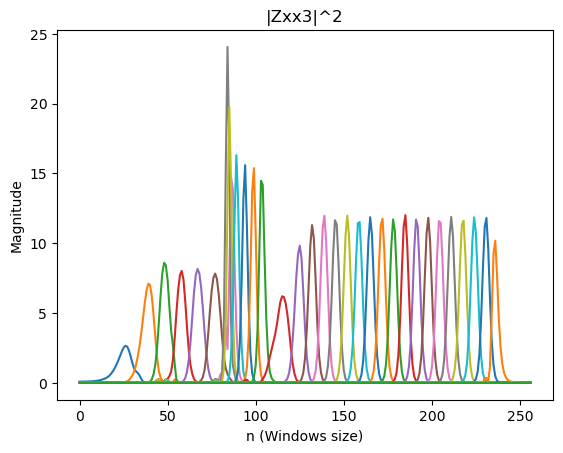

In [9]:
# Izračunavanje STFT
f, t, Zxx = stft(data3, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

plt.figure()
plt.plot(np.abs(Zxx)**2)
plt.title("|Zxx3|^2")
plt.xlabel('n (Windows size)')
plt.ylabel('Magnitude')

Na grafiku na kom vidimo magnitude ovog signala, vidimo da su magnitute signala smetnje dosta izražene. Vidimo jedan vrh (peak) koji je veoma izražen (sivi signal), te ostale koji su manje izraženi. Za usporedbu, uradićemo i STFT prvog i drugog zapisa

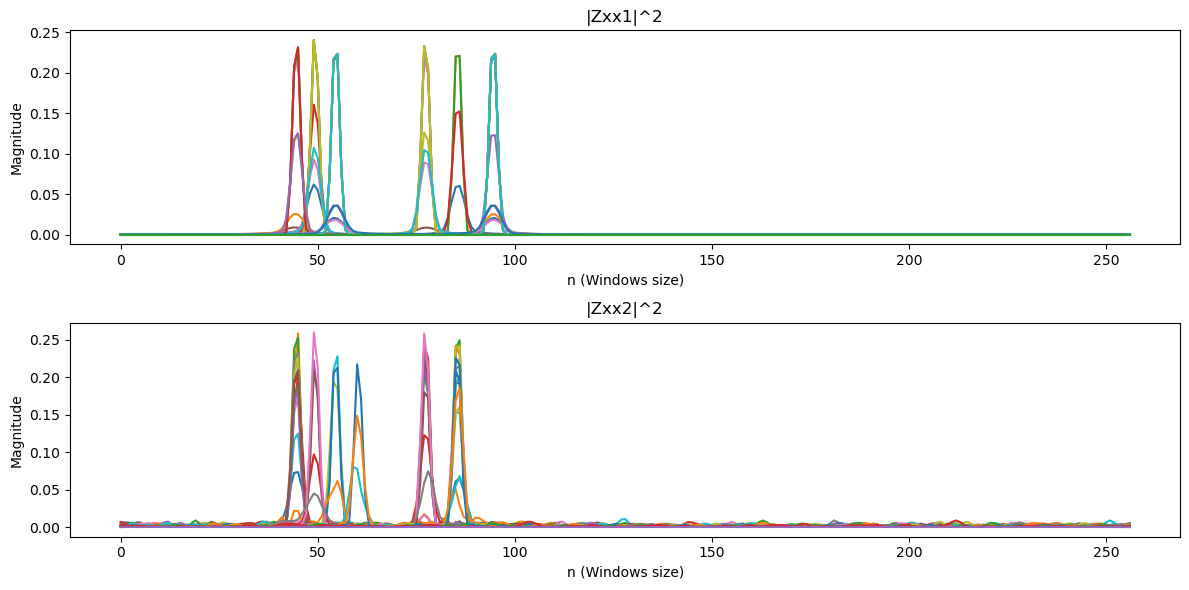

In [10]:
# Izračunavanje STFT
f, t, Zxx1 = stft(data1, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
f, t, Zxx2 = stft(data2, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(np.abs(Zxx1)**2)
plt.title("|Zxx1|^2")
plt.xlabel('n (Windows size)')
plt.ylabel('Magnitude')

plt.subplot(2,1,2)
plt.plot(np.abs(Zxx2)**2)
plt.title("|Zxx2|^2")
plt.xlabel('n (Windows size)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

Ovdje vidimo jasno izraženih 6 vrhova, koji zapravo predstavljaju naših 6 cifri, kako i na prvom, tako i na drugom spektru. Vidimo da na spektru $Zxx_{2}$ postoji šum, međutim magnituda mu je veoma mala, te se sa dobro definisanim naponom praga, na primjer, na 50% od maksimalne magnitude, veoma lako eliminišu te vrijednosti. 
Kad uporedimo ove spektre sa spektrom $Zxx_{3}$ vidimo da u spektru $Zxx_{3}$ ne možemo jasno da vidimo izražene vrhove, to jeste vidimo jako mnogo izraženih vrhova, gdje je jedan veoma izražen, a drugi su mnogo manji. Ako napravimo pretpostavku da se oko indeksa 100 na $Zxx_{3}$ nalaze vrijednosti cifara koje treba da očitamo, vidimo da se magnitude su magnitude izmežu 125 i 250 tolikog inteziteta da je razlika između najmanje magnitude korisnog signala i najveće magnitude šuma veoma mala. Uzimajući to u obzir, dolazimo do zaključka da je bi prag za detekciju frekvencija trebao biti veoma precizan i da bi i najmanja greška u tom pragu dovela do pogrešne detekcije ili čak nikakve detekcije. Ovome doprinosi i činjenica da je jedan vrh u spektru zapravo mnogo izraženiji od ostalih, te se prag za detekciju računa preko te vrijednosti. Možemo pretpostaviti da je toliki skokok u vrijednosti nastao zbog preklapanja šuma i korisnog signala. 

C:\Users\User\.conda\envs\odos\lib\site-packages\scipy\signal\_savitzky_golay.py:339: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)


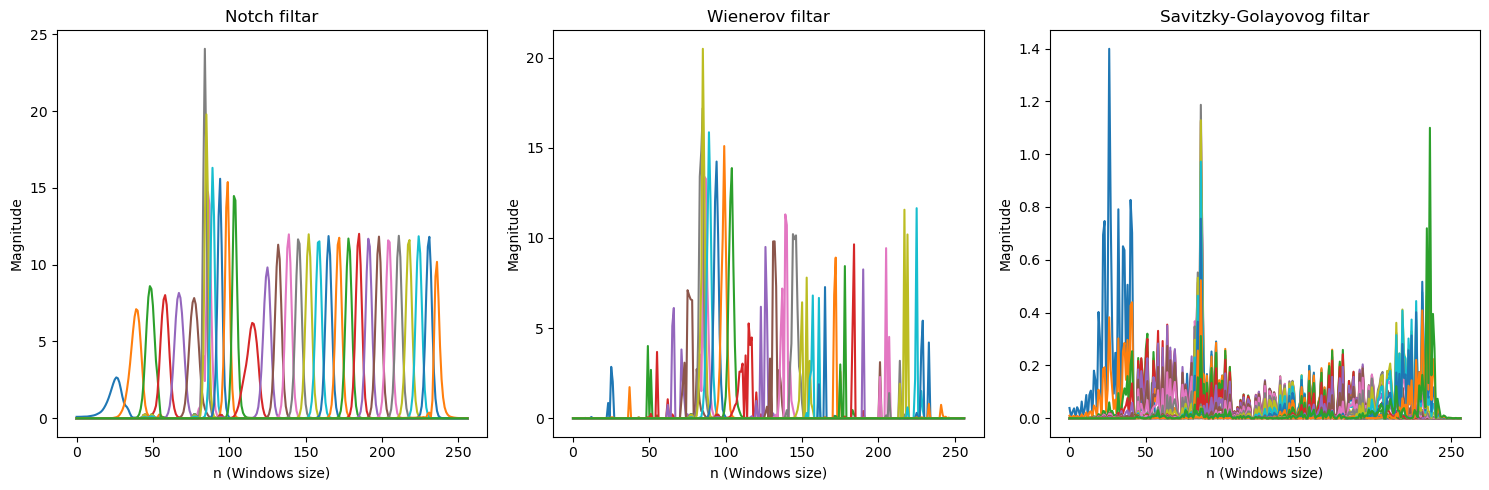

Decoded DTMF3 after Notch filter: 
Decoded DTMF3 after Wiener filter: 
Decoded DTMF3 after Savitzky-Golayov filter: 


In [11]:
# Parametri za Notch filtar
f0 = 500.0  # Osnovna frekvencija smetnji
num_freqs = 5  # Broj notch frekvencija
quality_factor = 10

b, a = iirnotch(f0/(fs/2), quality_factor, fs)
filtered_signal_notch = lfilter(b, a, Zxx)

# Generisanje više notch filtera za umnožak osnovne frekvencije
frequencies = f0 * np.arange(1, num_freqs+1)
for i in range(num_freqs):
    if i==0: 
        break
    else:
        frequency = f0 * (i + 1)
        w0 = frequency / (fs / 2)
        b, a = iirnotch(w0, quality_factor, fs)
        h=lfilter(b, a, Zxx)
        filtered_signal_notch +=h 


# Primjena Wienerovog filtra
mysize = 31  # Veličina prozora za Wienerov filtar
filtered_signal_wiener = wiener(Zxx, mysize)

# Primjena Savitzky-Golayovog filtra
window_length = 30  # Dužina prozora
polyorder = 5  # Red polinoma
filtered_signal_savgol = savgol_filter(Zxx, window_length, polyorder)


# Kreiranje subplot-a
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(np.abs(filtered_signal_notch)**2)
ax1.set_title("Notch filtar")
ax1.set_xlabel('n (Windows size)')
ax1.set_ylabel('Magnitude')

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(np.abs(filtered_signal_wiener)**2)
ax2.set_title("Wienerov filtar")
ax2.set_xlabel('n (Windows size)')
ax2.set_ylabel('Magnitude')

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(np.abs(filtered_signal_savgol)**2)
ax3.set_title("Savitzky-Golayovog filtar")
ax3.set_xlabel('n (Windows size)')
ax3.set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

# Inverzna STFT
_, reconstructed_signal_notch = istft(filtered_signal_notch, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
_, reconstructed_signal_wiener = istft(filtered_signal_wiener, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
_, reconstructed_signal_savgol = istft(filtered_signal_savgol, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft)

decoded_dtmf3_notch = decode_dtmf(reconstructed_signal_notch, fs, window, nperseg, noverlap, nfft)
decoded_dtmf3_wiener = decode_dtmf(reconstructed_signal_wiener, fs, window, nperseg, noverlap, nfft)
decoded_dtmf3_savgol = decode_dtmf(reconstructed_signal_savgol, fs, window, nperseg, noverlap, nfft)

print("Decoded DTMF3 after Notch filter:", decoded_dtmf3_notch)
print("Decoded DTMF3 after Wiener filter:", decoded_dtmf3_wiener)
print("Decoded DTMF3 after Savitzky-Golayov filter:", decoded_dtmf3_savgol)

Vidimo da primjenom raznih filtera na signal nakon STFT-a, te računanjem inverzne STFT i pokušavanjem dekodovanja, ponovo ne dobijamo nikakve vrijednosti. Za Notch filtar smo dobili vrijednosti na kojima se magnituda povećala, kao i razlika između korisnih vrijendosti i šuma, međutim, razlika je ponovo nedovoljna. Sličan slučaj je i sa Wiener filtrom, ali vidimo da je ovaj filtar uspio da smanji šumove znatno više od notch filtra, ali ponovo je nedovoljno za konkretne rezultate. Savgol filtar je, sa druge strane, potpuno uništio magnitude. Vidimo da su magnitude smetnji sada mnogo manje i zanemarljivije nego u prethodnim slučajevima, ali je ovaj filtar uništio i korisne frekvencije, tako da se ponovo ne mogu proitati korisne informacije. 

#### 5. Razmotriti cijenu i složenost implementacije algoritma. Šta bi se moglo učiniti kako bi dekoder bio jednostavniji i jeftiniji?

Što se tiče složenosti algoritma, neke stvari bi se mogle napraviti jednostavnije, ali po cijenu efikasnosti i preciznosti. <br>
Na primjer, ukoliko pogledamo samo prikazivanje spektrograma, kao i što je prije spomenuto, funkcijom <b><i>shading='gouraud'</i></b> dobijamo ljepše rezultate u spektogramu, međutim njena računska složenost je velika, te bismo mogli da koristimo podrazumjevanu vrijednost, a to je shading='default', međutim teže bismo pročitali željene vrijednosti sa spektograma. <br>
Ukoliko pogledamo funckiju za dekodovanje, vrijednosti željenih frekvencija i simbola vezanih za njih smo smjestili u mapu (dtmf_map) iz koje dolazimo relativno lako do vrijednosti koje želimo. Drugi način mi bio korištenje dvije odvojene matrice, za frekvencije, koje se nalaze u tuple-ovima, i za simbole, što bi bilo mnogo složenije, te bi zauzimalo više resursa. <br>
Takođe bi složenosti doprinijelo da su se provjeravale vrijednosti frekvencija koje su detektovane, to jest, da li postoje odgovarajuće vrijednosti, a ne uzimati minimalnu i maksimalnu vrijednost, što je već objašnjeno u prethodnom tekstu.

#### 6. Automatski odrediti trajanja pojedinih tonova u ms.


In [12]:
def decode_dtmf_tones_duration(ddata, dfs, dwindow, dnperseg, dnoverlap, dnfft):
    f, t, Zxx = stft(ddata, dfs, window=dwindow, nperseg=dnperseg, noverlap=dnoverlap, nfft=dnfft)    

    # Magnituda
    magnitude = np.abs(Zxx)**2

    # Prag za detekciju vremena
    threshold = 0.2*np.max(magnitude)
    
    
    # DTMF frekvencije i njihovo mapiranje na tastere
    dtmf_freqs_low = np.array([697, 770, 852, 941])
    dtmf_freqs_high = np.array([1209, 1336, 1477, 1633])
    dtmf_map = {(697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
                 (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
                 (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
                 (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'}

    # Funkcija za detekciju DTMF tonova i njihovih magnituda
    detected_tones = []
    
    for low_freq in dtmf_freqs_low:
        low_idx = np.argmin(np.abs(f - low_freq))
        for high_freq in dtmf_freqs_high:
            high_idx = np.argmin(np.abs(f - high_freq))
            low_magnitude = magnitude[low_idx, :]
            high_magnitude = magnitude[high_idx, :]
            if np.max(low_magnitude) > threshold and np.max(high_magnitude) > threshold:
                detected_tones.append(((low_freq, high_freq), low_magnitude, high_magnitude))
    
    #Funkcija za računanje vremena trajanja svakog tona
    tone_durations = {}
    for (low_freq, high_freq), low_magnitudes, high_magnitudes in detected_tones:
        active_idxs = (low_magnitudes > threshold ) & (high_magnitudes > threshold )
        active_times = t[active_idxs]
        if len(active_times) > 0:
            duration = (active_times[-1] - active_times[0]) * 1000  # Trajanje u ms od posljednjeg do prvog trenutka
            key = dtmf_map.get((low_freq, high_freq), 'Unknown') #Tražimo u riječniku, ako nema, podrazumjevano je Unknown 
            if key != 'Unknown':
                tone_durations[key] = round(duration, 4) 
    return tone_durations
    

In [13]:
# Dekodovanje signala
decoded_dtmf1_tone_duration = decode_dtmf_tones_duration(data1, fs, window, nperseg, noverlap, nfft)
decoded_dtmf2_tone_duration = decode_dtmf_tones_duration(data2, fs, window, nperseg, noverlap, nfft)
decoded_dtmf3_tone_duration = decode_dtmf_tones_duration(data3, fs, window, nperseg, noverlap, nfft)

#Ispis vremena trajanja svakog tastera
print("Duration of tones in DTMF1:", decoded_dtmf1_tone_duration)
print("Duration of tones in DTMF2:", decoded_dtmf2_tone_duration)
print("Duration of tones in DTMF3:", decoded_dtmf3_tone_duration)

Duration of tones in DTMF1: {'1': 40.0, '3': 40.0, '4': 60.0, '5': 60.0, '9': 360.0}
Duration of tones in DTMF2: {'1': 60.0, '2': 180.0, '4': 60.0, '8': 40.0, '0': 40.0}
Duration of tones in DTMF3: {}


U ispisu vidimo da nismo uspjeli dobiti nikakve informacije iz trećeg zapisa. <br>
Za prvi i drugi zapis, ukoliko uzmemo ispis brojeva, vidimo da se radi o sekvenci dtmf1: 519439 i dtmf2: 221840. U ispisu ovog koda vidimo koliko je neki taster bio pritisnut, to jeste, koliko je trajao, te možemo da potvrdimo tačnost koda, jer i kod za detekciju tona i kod za detekciju dužine trajanja tona daju iste brojeve. <br>
Optimizacija ovog koda bi bila da se po zadanoj sekvenci odredi koliko je koji taster bio pritisnut, a ne koliko je vrijeme trajanja tona nekog pojedinačnog tastera, grupisano u jednu zajedničku vrijednost. 